# Markov Chains

The purpose of this notebook is to explore Markov Chains as a statistical technique to predict outcomes of hitter/pitcher matchups. The data used will be statcast data, which shows every MLB hitting matchup throughout the course of a season. 

In [1]:
import pandas as pd
from configparser import ConfigParser
from sqlalchemy import create_engine
import matplotlib.pyplot as plt


In [2]:
# establish sql engine connection
parser = ConfigParser()
parser.read('nb.ini')
conn_string = parser.get('my_db', 'conn_string')
engine = create_engine(conn_string)

In [3]:
sql = '''
    SELECT COUNT(*) as count
    FROM statcast_2019
'''

results = engine.execute(sql)
engine.dispose()
rows = results.fetchall()

for row in rows:
    print(row)

(732071,)


In [4]:
sc_2019 = pd.read_sql_query("SELECT * FROM statcast_2019",
    engine)

sc_2019.head()

,index,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,year
0,0,218,SL,2019-10-30,87.9,-2.65,5.50,"Hudson, Daniel",488726,543339,...,6,2,2,6,Infield shift,Standard,175.0,-0.001,-0.137,2019
1,1,225,FF,2019-10-30,95.9,-2.77,5.52,"Hudson, Daniel",488726,543339,...,6,2,2,6,Infield shift,Standard,201.0,-0.001,0.000,2019
2,2,230,FF,2019-10-30,96.5,-2.68,5.42,"Hudson, Daniel",488726,543339,...,6,2,2,6,Infield shift,Standard,205.0,-0.001,0.038,2019
3,3,243,FF,2019-10-30,96.0,-2.65,5.55,"Hudson, Daniel",488726,543339,...,6,2,2,6,Infield shift,Standard,208.0,-0.001,-0.033,2019
4,4,244,SL,2019-10-30,86.7,-2.73,5.59,"Hudson, Daniel",488726,543339,...,6,2,2,6,Infield shift,Standard,186.0,-0.001,0.024,2019


### Note:

player_name is always the name of the pitcher. Reference player_lookup table under key_mlbam player id codes.

Refer to statcast data dictionary here: https://baseballsavant.mlb.com/csv-docs


In [5]:
player_lookup = pd.read_sql_query("SELECT * FROM player_lookup", engine)

player_lookup.head()

,index,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,0,Aardsma,David,430911,aardd001,aardsda01,1902,2004.0,2015.0
1,1,Aaron,Hank,110001,aaroh101,aaronha01,1000001,1954.0,1976.0
2,2,Aaron,Tommie,110002,aarot101,aaronto01,1000002,1962.0,1971.0
3,3,Aase,Don,110003,aased001,aasedo01,1000003,1977.0,1990.0
4,4,Abad,Andy,407577,abada001,abadan01,506,2001.0,2006.0


### Statcast Data Exploration

In [6]:
# events will be our dependent variable (possibly), let's explore it
# events contains the outcome of the at bat

sc_2019['events'].unique()

array(['strikeout', None, 'field_out', 'single', 'walk', 'force_out',
       'home_run', 'grounded_into_double_play', 'sac_bunt', 'double',
       'hit_by_pitch', 'sac_fly', 'field_error', 'fielders_choice_out',
       'triple', 'double_play', 'fielders_choice', 'catcher_interf',
       'sac_fly_double_play', 'strikeout_double_play', 'wild_pitch',
       'caught_stealing_2b', 'pickoff_1b', 'pickoff_3b', 'other_out',
       'pickoff_caught_stealing_home', 'caught_stealing_3b', 'pickoff_2b',
       'sac_bunt_double_play', 'triple_play', 'caught_stealing_home',
       'game_advisory', 'runner_double_play', 'stolen_base_2b',
       'pickoff_caught_stealing_3b', 'passed_ball'], dtype=object)

field_out                       72226
strikeout                       42705
single                          25938
walk                            15118
double                           8525
home_run                         6769
force_out                        3539
grounded_into_double_play        3454
hit_by_pitch                     1963
field_error                      1346
sac_fly                          1132
triple                            778
sac_bunt                          774
fielders_choice                   409
double_play                       403
fielders_choice_out               285
caught_stealing_2b                167
strikeout_double_play             159
catcher_interf                     61
other_out                          36
caught_stealing_home               12
sac_fly_double_play                12
caught_stealing_3b                 10
pickoff_1b                         10
wild_pitch                          5
pickoff_2b                          4
pickoff_caug

<AxesSubplot:>

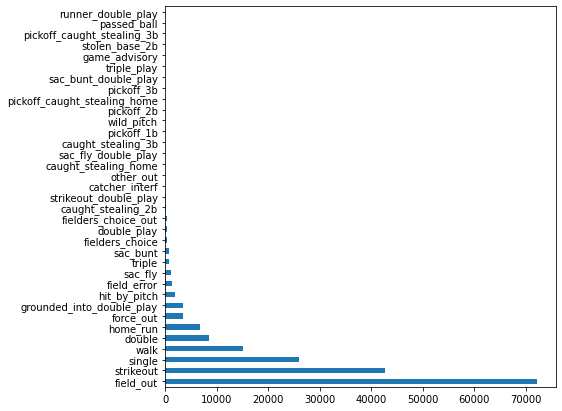

In [7]:
event_count = pd.value_counts(sc_2019['events'].values, sort=True)

plt.figure(figsize=(7,7))
print(sc_2019['events'].value_counts())
print('---------------------------------')
print('Count of unique events:')
print(sc_2019['events'].nunique())
event_count.plot.barh()

There are a total of 35 possible events in the statcast data with the most common being an out. These will need to be categorized down into 1B, 2B, 3B, HR, BB, K, BIP (ball in play). 

In [8]:
# description seems to be the outcome of a pitch
# just another layer of granularity

sc_2019['description'].unique()

array(['swinging_strike', 'foul', 'ball', 'called_strike',
       'hit_into_play', 'swinging_strike_blocked', 'blocked_ball',
       'hit_by_pitch', 'foul_bunt', 'foul_tip', 'missed_bunt', 'pitchout',
       'bunt_foul_tip'], dtype=object)

In [9]:
# des goes into more detail about the event (at bat level of granularity)

sc_2019['des'].unique()

array(['Michael Brantley strikes out swinging.',
       'Jose Altuve strikes out swinging.',
       'George Springer pops out to second baseman Asdrubal Cabrera.',
       ...,
       'Josh Bell singles on a sharp line drive to center fielder Scott Schebler.   Starling Marte scores.',
       'Corey Dickerson lines out to right fielder Yasiel Puig.',
       'Starling Marte reaches on a missed catch error by pitcher Sonny Gray, assist to first baseman Joey Votto.'],
      dtype=object)

In [10]:
# note that pitch_name might be easier to work with
# it spells out the pitch rather than abbreviations

sc_2019['pitch_type'].unique()

array(['SL', 'FF', 'CH', 'CU', 'SI', 'FT', 'FC', None, 'EP', 'KC', 'FS',
       'CS', 'FA', 'FO', 'KN'], dtype=object)

In [11]:
sc_2019['bb_type'].unique()

array([None, 'popup', 'fly_ball', 'ground_ball', 'line_drive'],
      dtype=object)

Fields needed:

game_date, player_name, batter, pitcher, events, description, game_type, type, bb_type, game_pk, pitch_number, pitch_name

## Data Cleaning/Prep

In [12]:
# define a dataset with required fields

df = sc_2019[['game_date', 'player_name', 'batter', 'pitcher', 'balls', 'strikes', 'events', 'description', 'game_type', 'type', 'bb_type', 'game_pk', 'pitch_number', 'pitch_name', 'pitch_type']]
df.head()

,game_date,player_name,batter,pitcher,balls,strikes,events,description,game_type,type,bb_type,game_pk,pitch_number,pitch_name,pitch_type
0,2019-10-30,"Hudson, Daniel",488726,543339,3,2,strikeout,swinging_strike,W,S,None,599377,7,Slider,SL
1,2019-10-30,"Hudson, Daniel",488726,543339,3,2,None,foul,W,S,None,599377,6,4-Seam Fastball,FF
2,2019-10-30,"Hudson, Daniel",488726,543339,2,2,None,ball,W,B,None,599377,5,4-Seam Fastball,FF
3,2019-10-30,"Hudson, Daniel",488726,543339,2,1,None,foul,W,S,None,599377,4,4-Seam Fastball,FF
4,2019-10-30,"Hudson, Daniel",488726,543339,1,1,None,ball,W,B,None,599377,3,Slider,SL


In [13]:
# this model will be limited to regular season games

df_reg = df.loc[df['game_type']=='R']

In [14]:
players = player_lookup[['name_last', 'name_first', 'key_mlbam']]

df_reg = df_reg.merge(players, how='left', left_on=['batter'], right_on=['key_mlbam'])
df_reg['batter_name'] = df_reg['name_first'] + ' ' + df_reg['name_last']
df_reg.rename(columns={'player_name': 'pitcher_name'}, inplace=True)

In [15]:
df_reg.isnull().sum()

game_date            0
pitcher_name         0
batter               0
pitcher              0
balls                0
strikes              0
events          537883
description          0
game_type            0
type                 0
bb_type         597161
game_pk              0
pitch_number         0
pitch_name        5088
pitch_type        5088
name_last            0
name_first           0
key_mlbam            0
batter_name          0
dtype: int64

There are a few nulls for pitch_name/pitch_type. This must be due to Statcast not being able to identify particular pitches but not confirmed. bb_type and events have a significant number of nulls but that's to be expected. 

In [16]:
df_reg.head()

,game_date,pitcher_name,batter,pitcher,balls,strikes,events,description,game_type,type,bb_type,game_pk,pitch_number,pitch_name,pitch_type,name_last,name_first,key_mlbam,batter_name
0,2019-09-28,"Stashak, Cody",670032,664054,1,1,field_out,hit_into_play,R,X,fly_ball,565781,3,None,None,Lopez,Nicky,670032,Nicky Lopez
1,2019-09-28,"Stashak, Cody",670032,664054,1,0,None,called_strike,R,S,None,565781,2,None,None,Lopez,Nicky,670032,Nicky Lopez
2,2019-09-26,"Stephenson, Robert",592325,596112,2,1,field_out,hit_into_play,R,X,popup,565300,4,None,None,Gamel,Ben,592325,Ben Gamel
3,2019-09-26,"Stephenson, Robert",592325,596112,2,0,None,swinging_strike,R,S,None,565300,3,None,None,Gamel,Ben,592325,Ben Gamel
4,2019-09-26,"Stephenson, Robert",592325,596112,1,0,None,ball,R,B,None,565300,2,None,None,Gamel,Ben,592325,Ben Gamel


In [17]:
df_reg.loc[df_reg['batter_name'] == 'Tim Anderson']

,game_date,pitcher_name,batter,pitcher,balls,strikes,events,description,game_type,type,bb_type,game_pk,pitch_number,pitch_name,pitch_type,name_last,name_first,key_mlbam,batter_name
328,2019-09-29,"Turnbull, Spencer",641313,605513,0,0,field_out,hit_into_play,R,X,line_drive,567343,1,Slider,SL,Anderson,Tim,641313,Tim Anderson
388,2019-09-29,"Turnbull, Spencer",641313,605513,0,1,field_out,hit_into_play,R,X,ground_ball,567343,2,Slider,SL,Anderson,Tim,641313,Tim Anderson
389,2019-09-29,"Turnbull, Spencer",641313,605513,0,0,None,called_strike,R,S,None,567343,1,4-Seam Fastball,FF,Anderson,Tim,641313,Tim Anderson
4906,2019-09-28,"Garcia, Bryan",641313,650530,0,2,strikeout,swinging_strike,R,S,None,567341,3,Slider,SL,Anderson,Tim,641313,Tim Anderson
4907,2019-09-28,"Garcia, Bryan",641313,650530,0,1,None,foul,R,S,None,567341,2,Slider,SL,Anderson,Tim,641313,Tim Anderson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720540,2019-03-31,"López, Jorge",641313,605347,0,0,single,hit_into_play,R,X,ground_ball,565704,1,2-Seam Fastball,FT,Anderson,Tim,641313,Tim Anderson
720589,2019-03-31,"López, Jorge",641313,605347,1,2,double,hit_into_play,R,X,line_drive,565704,4,Changeup,CH,Anderson,Tim,641313,Tim Anderson
720590,2019-03-31,"López, Jorge",641313,605347,1,1,None,foul,R,S,None,565704,3,2-Seam Fastball,FT,Anderson,Tim,641313,Tim Anderson
720591,2019-03-31,"López, Jorge",641313,605347,0,1,None,ball,R,B,None,565704,2,Knuckle Curve,KC,Anderson,Tim,641313,Tim Anderson


In [18]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720972 entries, 0 to 720971
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   game_date     720972 non-null  object
 1   pitcher_name  720972 non-null  object
 2   batter        720972 non-null  int64 
 3   pitcher       720972 non-null  int64 
 4   balls         720972 non-null  int64 
 5   strikes       720972 non-null  int64 
 6   events        183089 non-null  object
 7   description   720972 non-null  object
 8   game_type     720972 non-null  object
 9   type          720972 non-null  object
 10  bb_type       123811 non-null  object
 11  game_pk       720972 non-null  int64 
 12  pitch_number  720972 non-null  int64 
 13  pitch_name    715884 non-null  object
 14  pitch_type    715884 non-null  object
 15  name_last     720972 non-null  object
 16  name_first    720972 non-null  object
 17  key_mlbam     720972 non-null  int64 
 18  batter_name   720972 non

In [19]:
# convert data type to str, to combine into single 'count' feature

df_reg = df_reg.astype({'balls': 'str', 'strikes': 'str'})
df_reg['count'] = df_reg['balls'] + '-' + df_reg['strikes']

In [20]:
df_reg.head(20)

,game_date,pitcher_name,batter,pitcher,balls,strikes,events,description,game_type,type,bb_type,game_pk,pitch_number,pitch_name,pitch_type,name_last,name_first,key_mlbam,batter_name,count
0,2019-09-28,"Stashak, Cody",670032,664054,1,1,field_out,hit_into_play,R,X,fly_ball,565781,3,None,None,Lopez,Nicky,670032,Nicky Lopez,1-1
1,2019-09-28,"Stashak, Cody",670032,664054,1,0,None,called_strike,R,S,None,565781,2,None,None,Lopez,Nicky,670032,Nicky Lopez,1-0
2,2019-09-26,"Stephenson, Robert",592325,596112,2,1,field_out,hit_into_play,R,X,popup,565300,4,None,None,Gamel,Ben,592325,Ben Gamel,2-1
3,2019-09-26,"Stephenson, Robert",592325,596112,2,0,None,swinging_strike,R,S,None,565300,3,None,None,Gamel,Ben,592325,Ben Gamel,2-0
4,2019-09-26,"Stephenson, Robert",592325,596112,1,0,None,ball,R,B,None,565300,2,None,None,Gamel,Ben,592325,Ben Gamel,1-0
5,2019-09-26,"Stephenson, Robert",592325,596112,0,0,None,ball,R,B,None,565300,1,None,None,Gamel,Ben,592325,Ben Gamel,0-0
6,2019-09-26,"Stephenson, Robert",606115,596112,1,2,field_out,hit_into_play,R,X,fly_ball,565300,5,None,None,Arcia,Orlando,606115,Orlando Arcia,1-2
7,2019-09-26,"Stephenson, Robert",606115,596112,1,2,None,foul,R,S,None,565300,4,None,None,Arcia,Orlando,606115,Orlando Arcia,1-2
8,2019-09-26,"Stephenson, Robert",606115,596112,1,1,None,swinging_strike,R,S,None,565300,3,None,None,Arcia,Orlando,606115,Orlando Arcia,1-1
9,2019-09-26,"Stephenson, Robert",606115,596112,1,0,None,swinging_strike,R,S,None,565300,2,None,None,Arcia,Orlando,606115,Orlando Arcia,1-0


In [21]:
df_reg['count'].unique()

array(['1-1', '1-0', '2-1', '2-0', '0-0', '1-2', '0-2', '0-1', '2-2',
       '3-1', '3-0', '3-2', '4-1'], dtype=object)

In [22]:
df_reg.loc[df_reg['count']=='4-1']

,game_date,pitcher_name,batter,pitcher,balls,strikes,events,description,game_type,type,bb_type,game_pk,pitch_number,pitch_name,pitch_type,name_last,name_first,key_mlbam,batter_name,count
536501,2019-05-17,"Brebbia, John",523253,605154,4,1,field_out,hit_into_play,R,X,fly_ball,566783,6,4-Seam Fastball,FF,Forsythe,Logan,523253,Logan Forsythe,4-1


In [23]:
df_reg['events'].unique()

array(['field_out', None, 'strikeout', 'hit_by_pitch', 'single', 'walk',
       'home_run', 'double', 'grounded_into_double_play', 'force_out',
       'field_error', 'strikeout_double_play', 'double_play', 'sac_fly',
       'sac_bunt', 'triple', 'wild_pitch', 'fielders_choice_out',
       'caught_stealing_2b', 'fielders_choice', 'pickoff_1b',
       'catcher_interf', 'pickoff_3b', 'other_out', 'sac_fly_double_play',
       'pickoff_caught_stealing_home', 'caught_stealing_3b', 'pickoff_2b',
       'sac_bunt_double_play', 'triple_play', 'caught_stealing_home',
       'game_advisory', 'runner_double_play', 'stolen_base_2b',
       'pickoff_caught_stealing_3b', 'passed_ball'], dtype=object)

## Next Steps:

- Need to categorize all events into a walk/HBP, single, double, triple, HR and Out. Calculate the probabilities of each for the whole 2019 season.
- Note that a None event is just a pitch so this will indicate the next pitch of a sequence. 
- Then, at the individual player level, calculate the probabilities for each count/event.
- Code this dynamically so you can pick a player, and see a final matrix where the counts are your vertical axis and the event is the horizontal axis.
- You can then code it so you can have hitter/pitcher matchups

In [24]:
# calculate the transition probabilities
# walk/hit batsman, single, double, triple, HR, Out

df_trans = df_reg.copy()

In [25]:
df_trans.head()

,game_date,pitcher_name,batter,pitcher,balls,strikes,events,description,game_type,type,bb_type,game_pk,pitch_number,pitch_name,pitch_type,name_last,name_first,key_mlbam,batter_name,count
0,2019-09-28,"Stashak, Cody",670032,664054,1,1,field_out,hit_into_play,R,X,fly_ball,565781,3,None,None,Lopez,Nicky,670032,Nicky Lopez,1-1
1,2019-09-28,"Stashak, Cody",670032,664054,1,0,None,called_strike,R,S,None,565781,2,None,None,Lopez,Nicky,670032,Nicky Lopez,1-0
2,2019-09-26,"Stephenson, Robert",592325,596112,2,1,field_out,hit_into_play,R,X,popup,565300,4,None,None,Gamel,Ben,592325,Ben Gamel,2-1
3,2019-09-26,"Stephenson, Robert",592325,596112,2,0,None,swinging_strike,R,S,None,565300,3,None,None,Gamel,Ben,592325,Ben Gamel,2-0
4,2019-09-26,"Stephenson, Robert",592325,596112,1,0,None,ball,R,B,None,565300,2,None,None,Gamel,Ben,592325,Ben Gamel,1-0


In [33]:
# for the dict, I'm thinking bucket everything appropriately for the outcomes
# and everything else either becomes a 'None' or it stays the same
# the transition states should include each possible count
# the absorbed states come from the events - hit, out, K, BB, etc.

events_dict = {'field_out':'out', 'sac_fly':'out', 'strikeout':'K',
               'grounded_into_double_play':'out'}

In [35]:
df_trans['events_bucketed'] = df_trans['events'].replace(events_dict)

In [36]:
df_trans.head()

,game_date,pitcher_name,batter,pitcher,balls,strikes,events,description,game_type,type,...,game_pk,pitch_number,pitch_name,pitch_type,name_last,name_first,key_mlbam,batter_name,count,events_bucketed
0,2019-09-28,"Stashak, Cody",670032,664054,1,1,field_out,hit_into_play,R,X,...,565781,3,None,None,Lopez,Nicky,670032,Nicky Lopez,1-1,out
1,2019-09-28,"Stashak, Cody",670032,664054,1,0,None,called_strike,R,S,...,565781,2,None,None,Lopez,Nicky,670032,Nicky Lopez,1-0,None
2,2019-09-26,"Stephenson, Robert",592325,596112,2,1,field_out,hit_into_play,R,X,...,565300,4,None,None,Gamel,Ben,592325,Ben Gamel,2-1,out
3,2019-09-26,"Stephenson, Robert",592325,596112,2,0,None,swinging_strike,R,S,...,565300,3,None,None,Gamel,Ben,592325,Ben Gamel,2-0,None
4,2019-09-26,"Stephenson, Robert",592325,596112,1,0,None,ball,R,B,...,565300,2,None,None,Gamel,Ben,592325,Ben Gamel,1-0,None
